In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from google.colab import drive
import seaborn as sns
from tqdm.notebook import tqdm
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
unnormalized_data = pd.read_csv('drive/MyDrive/DSPRO/admission_data_clean_2.csv')

In [4]:
unnormalized_data = unnormalized_data.drop(['Unnamed: 0','month year','GENDER','TYPE OF ADMISSION-EMERGENCY/OPD','RURAL','GENDER','OUTCOME'],axis=1)

<Axes: >

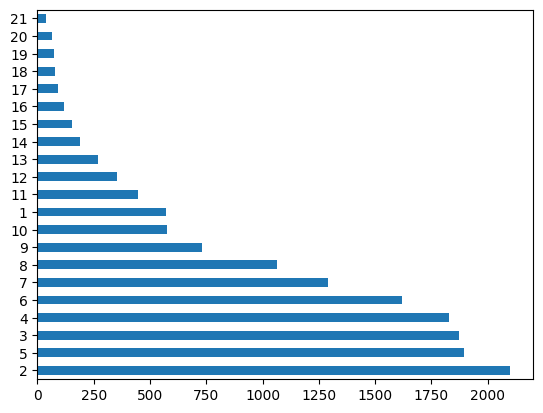

In [5]:
unnormalized_data['DURATION OF STAY'].sort_values().value_counts().plot(kind='barh')

### create short (2-6), middle (6-11) and long stay classes (11-21)
### short stay=**0**, middle stay=**1**,long stay=**2**

# Dataset = Imbalanced

In [6]:
class1_cond = ((unnormalized_data['DURATION OF STAY'] >= 0) & (unnormalized_data['DURATION OF STAY']<=5))
class2_cond = ((unnormalized_data['DURATION OF STAY'] >= 6) & (unnormalized_data['DURATION OF STAY']<=11))
class3_cond = ((unnormalized_data['DURATION OF STAY'] >= 12) & (unnormalized_data['DURATION OF STAY']<=21))


unnormalized_data['stay_class'] = np.where((class1_cond), 0,np.where((class2_cond),1,np.where((class3_cond),2,0)))

unnormalized_data.to_csv('unnormalized_data_with_stay_class.csv')

unnormalized_data.head()


,AGE,DURATION OF STAY,duration of intensive unit stay,SMOKING,ALCOHOL,DM,HTN,CAD,PRIOR CMP,CKD,...,UTI,NEURO CARDIOGENIC SYNCOPE,ORTHOSTATIC,INFECTIVE ENDOCARDITIS,DVT,CARDIOGENIC SHOCK,SHOCK,PULMONARY EMBOLISM,CHEST INFECTION,stay_class
0,81,3,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65,5,2,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,53,3,3,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67,8,6,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,44,10,8,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

unnormalized_data['stay_class'].value_counts()

0    8266
1    5726
2    1418
Name: stay_class, dtype: int64

In [8]:
X = unnormalized_data.iloc[:, 0:-1]
y = unnormalized_data.iloc[:, -1]

In [9]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=33)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=42)

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
def get_class_distribution(obj):
    count_dict = {
        "0": 0,
        "1": 0,
        "2": 0
    }

    for i in obj:
        if i == 0:
            count_dict['0'] += 1
        elif i == 1:
            count_dict['1'] += 1
        elif i == 2:
            count_dict['2'] += 1
        else:
            print("Check classes.")

    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

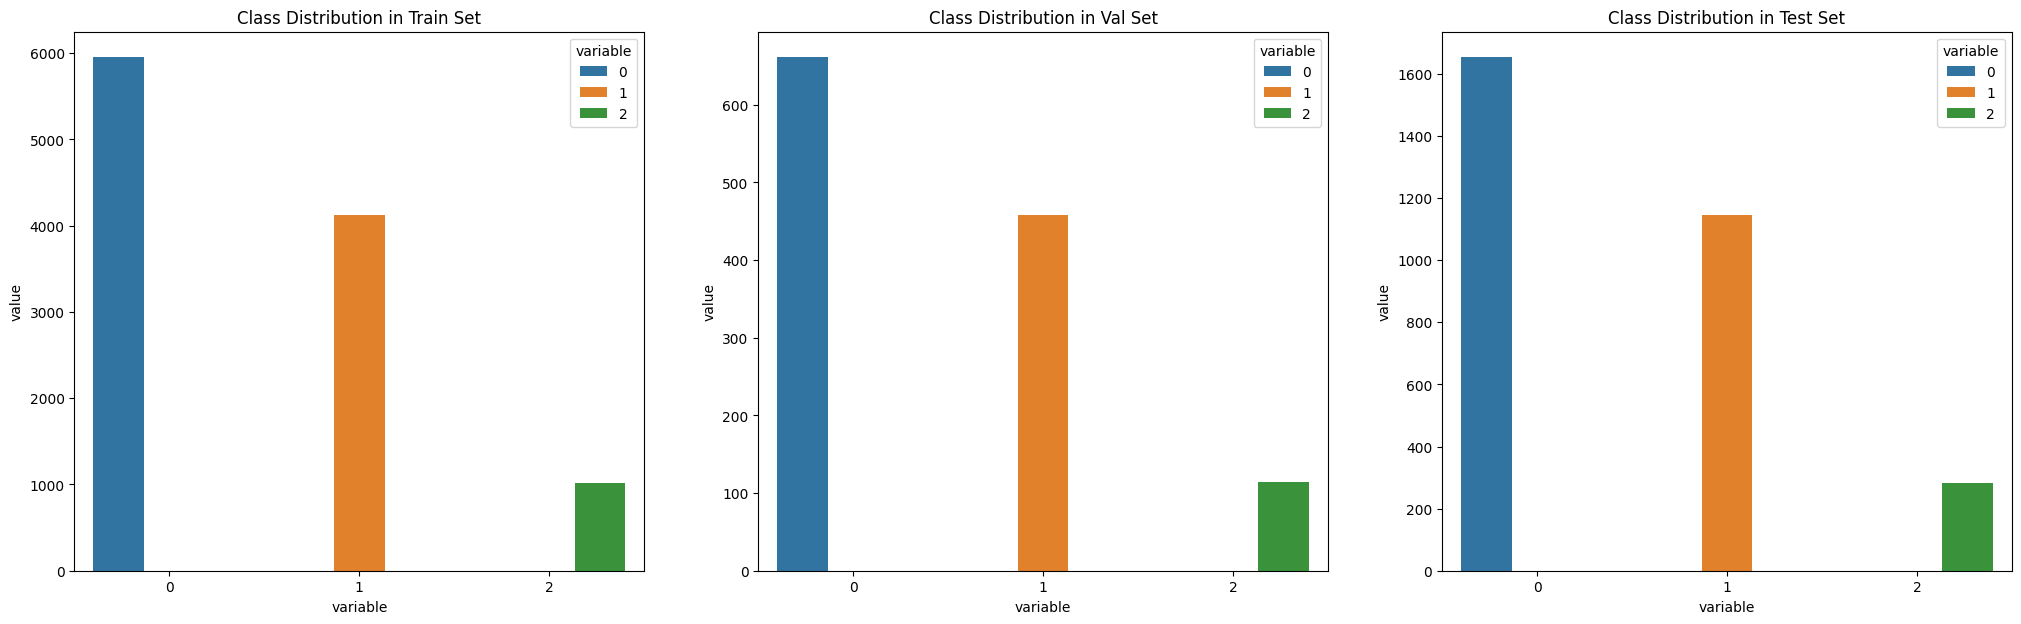

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [14]:
class ClassifierDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [15]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())

val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [16]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)

target_list = torch.tensor(target_list)

In [17]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
print(f'0: {class_count[0]} 1: {class_count[1]} 2: {class_count[2]} \n Class Weights: {class_weights}')

0: 5952 1: 4123 2: 1020 
 Class Weights: tensor([0.0002, 0.0002, 0.0010])


In [18]:
torch.bincount(target_list)

tensor([5952, 4123, 1020])

In [19]:
class_weights_all = class_weights[target_list]

In [20]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [21]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.00007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 3

In [22]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=64,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)
test_loader = DataLoader(dataset=test_dataset, batch_size=16)

In [72]:
class LOSClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(NUM_FEATURES, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, NUM_CLASSES)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)

        return x

In [24]:
model = LOSClassification()
model.to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

LOSClassification(
  (layer_1): Linear(in_features=47, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [25]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc

In [44]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [45]:

for epoch in tqdm(range(1,EPOCHS+1)):

  train_epoch_loss = 0
  train_epoch_acc = 0

  model.train()
  for X_train_batch, y_train_batch in train_loader:

     X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

     optimizer.zero_grad()

     y_train_pred = model(X_train_batch)

     train_loss = loss_fn(y_train_pred, y_train_batch)
     train_acc = multi_acc(y_train_pred,y_train_batch)

     train_loss.backward()
     optimizer.step()

     train_epoch_loss += train_loss.item()
     train_epoch_acc += train_acc.item()

     model.eval()

     with torch.inference_mode():

      val_epoch_loss = 0
      val_epoch_acc = 0

      for X_val_batch, y_val_batch in val_loader:

        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

        y_val_pred = model(X_val_batch)

        val_loss = loss_fn(y_val_pred, y_val_batch)
        val_acc = multi_acc(y_val_pred, y_val_batch)

        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

  print(f'Epoch {epoch+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.11057 | Val Loss: 0.19491 | Train Acc: 93.259| Val Acc: 91.218
Epoch 002: | Train Loss: 0.09650 | Val Loss: 0.17264 | Train Acc: 94.017| Val Acc: 92.026
Epoch 003: | Train Loss: 0.08386 | Val Loss: 0.15105 | Train Acc: 95.023| Val Acc: 93.872
Epoch 004: | Train Loss: 0.07611 | Val Loss: 0.15464 | Train Acc: 95.586| Val Acc: 93.397
Epoch 005: | Train Loss: 0.07542 | Val Loss: 0.14377 | Train Acc: 95.943| Val Acc: 93.923
Epoch 006: | Train Loss: 0.06890 | Val Loss: 0.12673 | Train Acc: 96.339| Val Acc: 95.064
Epoch 007: | Train Loss: 0.06534 | Val Loss: 0.13887 | Train Acc: 96.655| Val Acc: 94.103
Epoch 008: | Train Loss: 0.06492 | Val Loss: 0.13917 | Train Acc: 96.431| Val Acc: 93.654
Epoch 009: | Train Loss: 0.06142 | Val Loss: 0.12045 | Train Acc: 96.862| Val Acc: 95.385
Epoch 010: | Train Loss: 0.05993 | Val Loss: 0.11150 | Train Acc: 97.000| Val Acc: 96.064
Epoch 011: | Train Loss: 0.05711 | Val Loss: 0.12193 | Train Acc: 96.954| Val Acc: 94.615
Epoch 012:

KeyboardInterrupt: ignored

In [39]:
accuracy_stats['train']

[50.12068965517241,
 71.00574712643679,
 83.1264367816092,
 87.3103448275862,
 89.00574712643679,
 90.91954022988506,
 91.97126436781609,
 92.87931034482759]

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

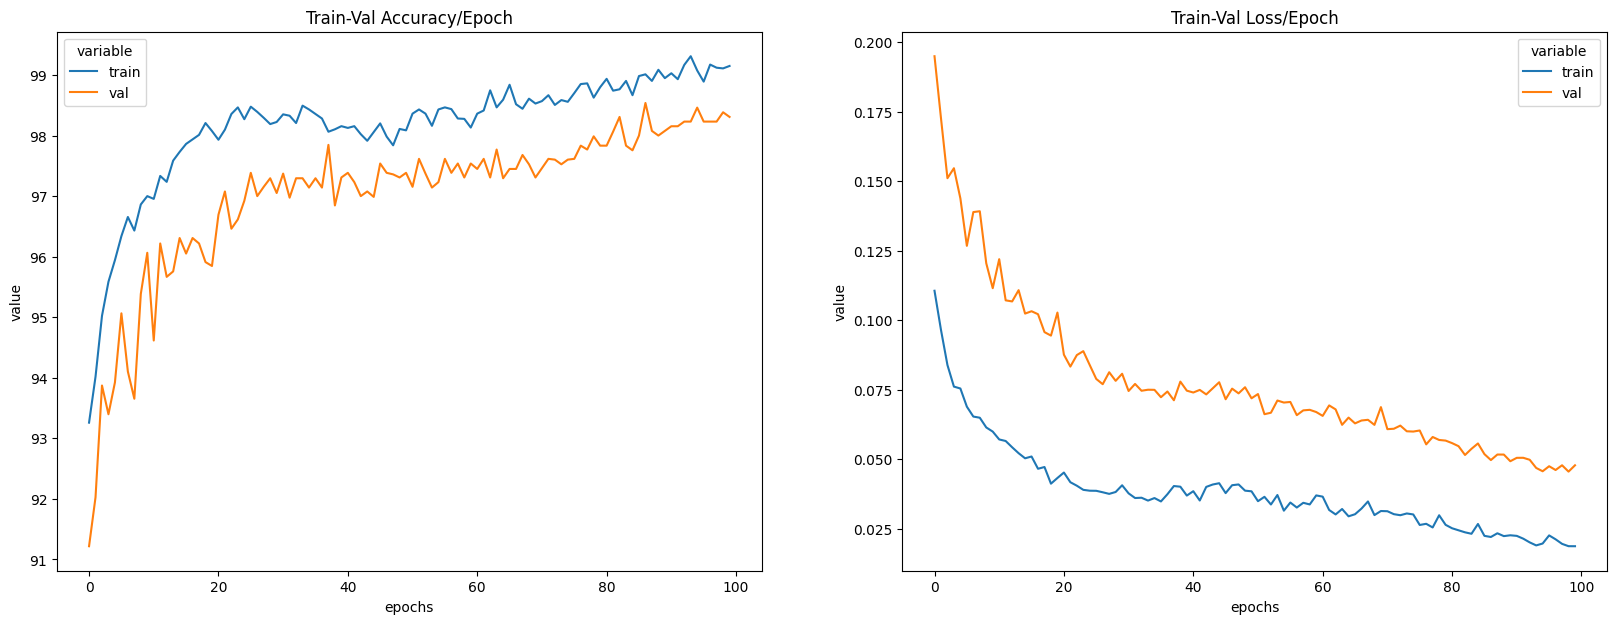

In [46]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [47]:
torch.save(model.state_dict(), 'LOSModel2.pt')

# Test

In [121]:
model1 = LOSClassification()
model1.load_state_dict(torch.load('drive/MyDrive/DSPRO/LOSModel2.pt'))

y_test_pred_list = []

model1.eval()

with torch.inference_mode():
  for X_batch, _ in test_loader:
    X_batch = X_batch.to(device)
    y_test_pred = model1(X_batch)

    for preds in y_test_pred:
      _,y_pred_tags = torch.max(preds,dim=0)
      y_test_pred_list.append(y_pred_tags.cpu().numpy().squeeze())

y_test_pred_list = [a.squeeze().tolist() for a in y_test_pred_list]

In [124]:
y_test_pred_list[:15]

[2, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]

In [126]:
y_test[:15]

array([2, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

<Axes: >

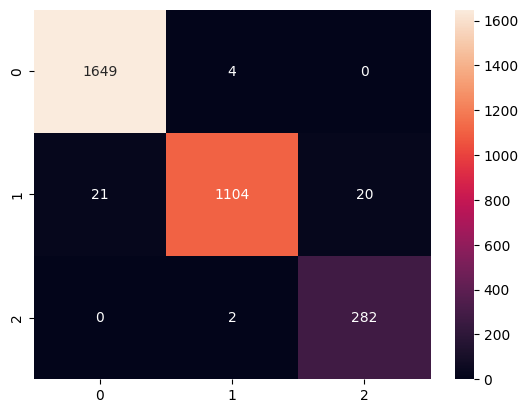

In [127]:
confusion_matrix_df=pd.DataFrame(confusion_matrix(y_test,y_test_pred_list))
sns.heatmap(confusion_matrix_df, annot=True,fmt="d")

In [128]:
print(classification_report(y_test,y_test_pred_list))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1653
           1       0.99      0.96      0.98      1145
           2       0.93      0.99      0.96       284

    accuracy                           0.98      3082
   macro avg       0.97      0.98      0.98      3082
weighted avg       0.99      0.98      0.98      3082

